In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D,Input, Dropout, Flatten, Activation, AveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
from numpy import expand_dims
import pandas as pd
import random
from pathlib import Path
from IPython.display import display
from PIL import Image
import pickle
import glob
import os
import cv2

In [2]:
os.listdir('/drive/My Drive/FaceMask/Dataset')

['Train', 'Test', 'Validation']

### Init the directory and variables


In [3]:
mainDirectory = '/drive/My Drive/FaceMask/Dataset/'
trainDirectory = mainDirectory+'Train/'
testDirectory = mainDirectory+'Test/'
validationDirectory = mainDirectory+'Validation/'

In [4]:
EPOCHS = 5
BATCH_SIZE = 256

### Augmentasi data

In [5]:
aug = ImageDataGenerator(
    rescale=1.0/255)

In [6]:
datatrain = aug.flow_from_directory(trainDirectory,
                                batch_size=BATCH_SIZE,
                                class_mode='binary',
                                target_size=(64,64))

datatest = aug.flow_from_directory(testDirectory,
                                batch_size=BATCH_SIZE,
                                class_mode='binary',
                                target_size=(64,64))

datavalidation = aug.flow_from_directory(validationDirectory,
                                batch_size=BATCH_SIZE,
                                class_mode='binary',
                                target_size=(64,64))

Found 13253 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Build Model

In [8]:
model = Sequential([
    Conv2D(64, kernel_size=(4,4), strides=2, activation='relu', padding='same', input_shape=(64,64,3)),
    MaxPooling2D(),
    Conv2D(128, kernel_size=(4,4), strides=2, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(256, kernel_size=(4,4), strides=2, activation='relu', padding='same'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 256)         524544    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 256)        

In [10]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

### TRAIN

In [11]:
history = model.fit(datatrain,
                    epochs=EPOCHS,
                    validation_data=datavalidation)

Epoch 1/5
52/52 [==============================] - 1921s 37s/step - loss: 0.5033 - accuracy: 0.7561 - val_loss: 0.2338 - val_accuracy: 0.9312
Epoch 2/5
52/52 [==============================] - 58s 1s/step - loss: 0.2951 - accuracy: 0.8627 - val_loss: 0.1222 - val_accuracy: 0.9675
Epoch 3/5
52/52 [==============================] - 58s 1s/step - loss: 0.2160 - accuracy: 0.9011 - val_loss: 0.0745 - val_accuracy: 0.9688
Epoch 4/5
52/52 [==============================] - 56s 1s/step - loss: 0.1853 - accuracy: 0.9150 - val_loss: 0.0346 - val_accuracy: 0.9850
Epoch 5/5
52/52 [==============================] - 55s 1s/step - loss: 0.1635 - accuracy: 0.9255 - val_loss: 0.0294 - val_accuracy: 0.9887


In [13]:
model.save("/drive/My Drive/FaceMask/model.h5")

## EVALUATE MODEL

In [14]:
results = model.evaluate(datatest)

4/4 [==============================] - 291s 73s/step - loss: 0.0389 - accuracy: 0.9849


## PLOT RESULT

In [17]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

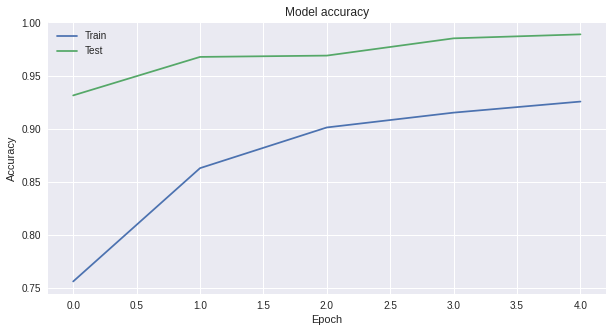

In [18]:
plt.rcParams['figure.figsize'] = [10, 5]

# Plot training & validation accuracy values
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('/drive/My Drive/FaceMask/accuracy.png')
plt.legend(['Train', 'Test'])

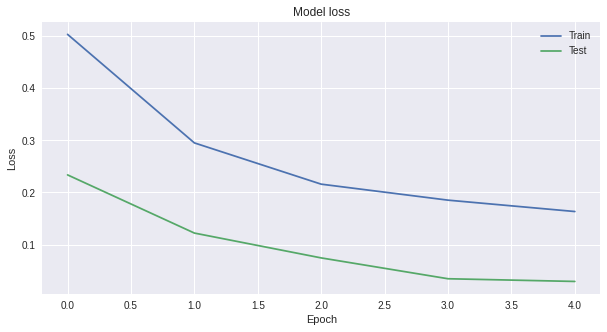

In [19]:
# Plot training & validation loss values
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('/drive/My Drive/FaceMask/lost.png')
plt.legend(['Train', 'Test'])

## PREDICT

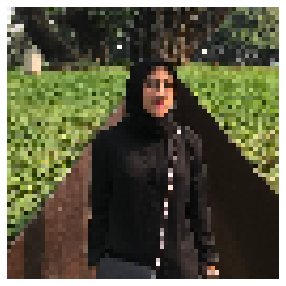

In [26]:
img = image.load_img('/drive/My Drive/FaceMask/data/4.jpg',target_size=(64,64))
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
img = np.array(img, dtype='float')
img = img.reshape(1, 64, 64, 3)
prediksi = model.predict(img)
idx = np.argmax(prediksi)
percentage = "%.2f" % (prediksi[0][idx] * 100)
print(str(percentage)+" %")
if (idx):
    print("Wearing Masker")
else:
    print("Not Wearing Masker")

100.00 %
Not Wearing Masker
